In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.contrib.layers import xavier_initializer,conv2d_transpose
from tensorflow.contrib.layers import flatten
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.ndimage.interpolation import rotate,zoom
from sklearn.preprocessing import OneHotEncoder, normalize, MinMaxScaler
from scipy.misc import imresize
import logging

# Data set

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Helper functions

In [3]:
def _weights(name, shape,initializer = 'truncated', mean=0.0, stddev=0.02):
    """ Helper to create an initialized Variable
    
    Args:
        name: name of the variable
        shape: list of ints
        initializer: either truncated normal or xavier
        mean: mean of a Gaussian
        stddev: standard deviation of a Gaussian
        
    
    Returns:
        A trainable variable
    """
    if initializer == 'xavier':
        var = tf.get_variable(name, shape,
        initializer= xavier_initializer)
    elif initializer == 'truncated':
        var = tf.get_variable(name, shape,
        initializer=tf.truncated_normal_initializer(
          mean=mean, stddev=stddev, dtype=tf.float32))
    return var

def _biases(name, shape, constant=0.0):
    """ 
    Helper to create an initialized Bias with constant
    """
    return tf.get_variable(name, shape,
            initializer=tf.constant_initializer(constant))

In [4]:
def _leakyReLU(x,alpha = 0.2):
    return tf.maximum(alpha*x,x)

In [5]:
def _instance_norm(x,depth = None):
    """ 
    Instance Normalization
    """
    if depth == None:
        depth = x.get_shape()[3]
    with tf.variable_scope("instance_norm"):
        scale = _weights("scale", [depth], 'truncated',mean=1.0)
        offset = _biases("offset", [depth])
        mean, variance = tf.nn.moments(x, axes=[1,2], keep_dims=True)
        epsilon = 1e-5
        inv = tf.rsqrt(variance + epsilon)
        normalized = (x-mean)*inv
    return scale*normalized + offset

In [6]:
def _residual_block(x):
    """ A residual block that contains two 3x3 convolutional layers
      with the same number of filters on both layer
      See http://torch.ch/blog/2016/02/04/resnets.html
    Args:
        input: 4D Tensor

    Returns:
        4D tensor (same shape as input)
    """
    n_channels = x.get_shape()[3] 
    
    with tf.variable_scope('layer1'):
        weights = _weights("weights",shape=[3, 3, n_channels, n_channels])
        padded = tf.pad(x, [[0,0],[1,1],[1,1],[0,0]], 'REFLECT')
        conv = tf.nn.conv2d(padded, weights,
          strides=[1, 1, 1, 1], padding='VALID')
        normalised = _instance_norm(conv)
        relu = tf.nn.relu(normalised)

    with tf.variable_scope('layer2'):
        weights = _weights("weights",shape=[3, 3, n_channels, n_channels])
        padded = tf.pad(relu, [[0,0],[1,1],[1,1],[0,0]], 'REFLECT')
        conv = tf.nn.conv2d(padded, weights,
          strides=[1, 1, 1, 1], padding='VALID')
        normalised = _instance_norm(conv)
        
    output = x+normalised
    
    return output

In [7]:
def generator(x):
    """
    The generator takes an input of an image
    and seek to transform that image into another image
    Args:
        x: 2D Tensor
    
    Returns:
        4D tensor
    """
    x = tf.reshape(x,[-1,28,28,1])
    # the convolutional layers (down sampling)
    with tf.variable_scope('conv1') as scope:
        weights = _weights("weights",shape=[5, 5, 1, 8])
        padded = tf.pad(x,[[0,0],[2,2],[2,2],[0,0]],'REFLECT')
        conv = tf.nn.conv2d(padded, weights,
          strides=[1, 1, 1, 1], padding='VALID')
        normalised = _instance_norm(conv)
        output = _leakyReLU(normalised)
    
    with tf.variable_scope('conv2') as scope:
        weights = _weights("weights",shape=[3, 3, 8, 16])
        conv = tf.nn.conv2d(output, weights,
          strides=[1, 2, 2, 1], padding='SAME')
        normalised = _instance_norm(conv)
        output = _leakyReLU(normalised)
    
    with tf.variable_scope('conv3') as scope:
        weights = _weights("weights",shape=[3, 3, 16, 32])
        conv = tf.nn.conv2d(output, weights,
          strides=[1, 2, 2, 1], padding='SAME')
        normalised = _instance_norm(conv)
        output = _leakyReLU(normalised)
    
    # the residual blocks
    with tf.variable_scope('residual1') as scope:
        output = _residual_block(output)
    
    with tf.variable_scope('residual2') as scope:
        output = _residual_block(output)
        
        
    # the fractional convolutions (up sampling)
    
    static_input_shape = output.get_shape().as_list()
    dyn_input_shape = tf.shape(output)

    with tf.variable_scope('frac_conv1') as scope:
        weights = _weights("weights", shape=[3, 3, 16, static_input_shape[3]])
        output_size = dyn_input_shape[1]*2
        #output_shape = [batch_size, output_size, output_size, 8]
        output_shape = tf.stack([dyn_input_shape[0],output_size,output_size,16])

        fsconv = tf.nn.conv2d_transpose(output, weights,output_shape=output_shape,
                                        strides=[1, 2, 2, 1], padding='SAME')
        normalized = _instance_norm(fsconv,16)
        output = _leakyReLU(normalized)
    
    static_input_shape = output.get_shape().as_list()
    dyn_input_shape = tf.shape(output)
    with tf.variable_scope('frac_conv2') as scope:
        weights = _weights("weights", shape=[3, 3, 8, static_input_shape[3]])
        output_size = dyn_input_shape[1]*2
        #output_shape = [batch_size, output_size, output_size, 1]
        output_shape = tf.stack([dyn_input_shape[0],output_size,output_size,8])
        fsconv = tf.nn.conv2d_transpose(output, weights,output_shape=output_shape,
                                        strides=[1, 2, 2, 1], padding='SAME')
        normalized = _instance_norm(fsconv,8)
        output = _leakyReLU(normalized)
        
    # the convolutional layers (down sampling)
    with tf.variable_scope('output') as scope:
        weights = _weights("weights",shape=[5, 5, 8, 1])
        padded = tf.pad(output, [[0,0],[2,2],[2,2],[0,0]], 'REFLECT')
        conv = tf.nn.conv2d(padded, weights,
        strides=[1, 1, 1, 1], padding='VALID')
        output = tf.nn.tanh(conv)
        
    return output

In [8]:
def discriminator(x):
    """
    The discriminator takes an input of an image
    and outputs a probability whether the image is produced
    from the generator (fake) or is from the data set (real)
    Args:
        x: 4D Tensor
    
    Returns:
        1
    """
    x = tf.reshape(x,[-1,28,28,1])
    
    with tf.variable_scope("conv1") as scope:
        weights = _weights("weights",shape=[3, 3, 1, 8])
        conv = tf.nn.conv2d(x, weights,strides=[1, 2, 2, 1], padding='SAME')
        normalised = _instance_norm(conv)
        output = _leakyReLU(normalised)
        
    with tf.variable_scope("conv2") as scope:
        weights = _weights("weights",shape=[3, 3, 8, 16])
        conv = tf.nn.conv2d(output, weights,strides=[1, 2, 2, 1], padding='SAME')
        normalised = _instance_norm(conv)
        output = _leakyReLU(normalised)
        
    with tf.variable_scope("conv3") as scope:
        weights = _weights("weights",shape=[3, 3, 16, 32])
        conv = tf.nn.conv2d(output, weights,strides=[1, 2, 2, 1], padding='SAME')
        normalised = _instance_norm(conv)
        output = _leakyReLU(normalised)
        
    flatten_layer = flatten(output)
    dim = flatten_layer.get_shape().as_list()[1]
    
    with tf.variable_scope("fc1") as scope:
        weights = _weights("weights",shape=[dim, 512])
        biases = _biases("biases",shape=[512])
        layer = tf.nn.bias_add(tf.matmul(flatten_layer,weights),biases)
        output = _leakyReLU(layer)
    
    with tf.variable_scope("fc2") as scope:
        weights = _weights("weights",shape=[512, 1])
        biases = _biases("biases",shape=[1])
        layer = tf.nn.bias_add(tf.matmul(output,weights),biases)
    
    return layer

In [9]:
x_ph_A = tf.placeholder(tf.float32,[None,28*28])
x_ph_B = tf.placeholder(tf.float32,[None,28*28])

In [10]:
with tf.variable_scope("G_B"):
    genB = generator(x_ph_A)
with tf.variable_scope("D_B") as scope:
    dB_real = discriminator(x_ph_B)
    scope.reuse_variables()
    dB_fake = discriminator(genB)

In [11]:
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = dB_real, labels = tf.ones_like(dB_real)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = dB_fake, labels = tf.zeros_like(dB_fake)))
D_loss = D_loss_real + D_loss_fake
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = dB_fake, labels = tf.ones_like(dB_fake)))

In [12]:
def make_optimiser(loss, variables,name, optimiser = 'Adam', beta1 = 0.5,learning_rate = 2e-4):
    """ 
    Make an optimiser with initial given learning rate that stays constant for the first 100 epochs
    and decays linearly afterwards
    """
    global_step = tf.Variable(0, trainable=False)
    starter_learning_rate = learning_rate
    end_learning_rate = 0.0
    start_decay_step = 100000
    decay_steps = 100000
    
    # make the learning rate that is constant initially, and then linearly decreases after
    # start_decay_step
    learning_rate = (
          tf.where(
                  tf.greater_equal(global_step, start_decay_step),
                  tf.train.polynomial_decay(starter_learning_rate, global_step-start_decay_step,
                                            decay_steps, end_learning_rate,
                                            power=1.0),
                  starter_learning_rate
          )
      )
    if optimiser == 'Adam':
        learning_step = tf.train.AdamOptimizer(learning_rate, beta1=beta1,name=name).minimize(loss, global_step=global_step, var_list=variables)

    elif optimiser == 'SGD':
        learning_step = tf.train.GradientDescentOptimizer(learning_rate,name=name).minimize(loss, global_step=global_step, var_list=variables)
    
    return learning_step

In [13]:
variables = tf.trainable_variables()
dB_params = [v for v in variables if v.name.startswith('D_B/')]
genB_params = [v for v in variables if v.name.startswith('G_B/')]

genB_optimiser = make_optimiser(G_loss, genB_params,'Adam_genB')
dB_optimiser = make_optimiser(D_loss, dB_params,'Adam_dB')

In [14]:
with tf.control_dependencies([genB_optimiser, dB_optimiser]):
    optimisers = tf.no_op(name='optimisers')

In [15]:
# build some summary statistics on tensorboard
tf.summary.histogram('dB/true', dB_real)
tf.summary.histogram('dB/fake', dB_fake)

tf.summary.scalar('loss/genB', G_loss)
tf.summary.scalar('loss/dB', D_loss)


summary_op = tf.summary.merge_all()

In [16]:
checkpoints_dir = 'model_invert'
graph = tf.get_default_graph()
train_writer = tf.summary.FileWriter(checkpoints_dir, graph)

# Training

In [17]:
def invert_image(batch):
    return 1.0-batch

In [18]:
def add_noise(batch):
    return np.clip(batch + np.random.normal(0,0.4,size =(len(batch),28*28)),0,1)

In [19]:
def rotate_image(batch):
    for j in range(batch.shape[0]):
        
        #sample a random float between -pi and pi
        sample = np.random.uniform(-150.0,-210.0)
        
        # rotate and flatten image
        batch[j] = rotate(np.reshape(batch[j],(28,28)),sample,reshape=False).flatten()
    
    return normalize(batch)

In [20]:
def flip_image(batch):
    for j in range(batch.shape[0]):
  
        # rotate and flatten image
        batch[j] = np.flip(np.reshape(batch[j],(28,28)),axis=1).flatten()
    return batch

In [21]:
batch_size = 150
n_epoch = 5

The first test we will train is to change the white to black and black to white. As shown below

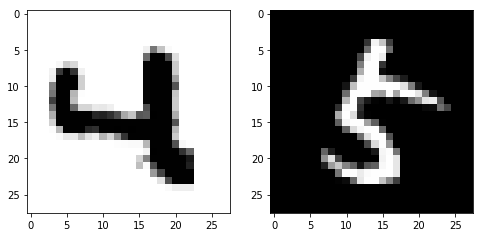

In [22]:
# test whether the scaling works
train_batch, _ = mnist.train.next_batch(batch_size)
# assign each batch some 'scanner' labels
labels = np.random.choice(2,batch_size)

flipped_batch = invert_image(train_batch[labels == 0])
normal_batch = train_batch[labels == 1]
# plot the
plt.figure(figsize=(8,8))
plt.subplot(121)
plt.imshow(np.reshape(flipped_batch[0],(28,28)),cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(normal_batch[0],(28,28)),cmap='gray')

In [23]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
step = 0.0

In [24]:
for epoch in range(n_epoch):
    n_iter = 50000/batch_size
    
    for i in range(n_iter):
        
        # get the next batch
        train_batch, _ = mnist.train.next_batch(batch_size)
        
        # assign each batch to some 'scanner' labels
        labels = np.random.choice(2,batch_size)
        
        # apply the transformations
        #noise_batch = add_noise(train_batch[labels == 0])
        inverted_batch = invert_image(train_batch[labels == 0])
        normal = train_batch[labels == 1]
        
        _, genB_loss_val,dB_loss_val,summary = (
              sess.run(
                  [optimisers,G_loss,D_loss,summary_op],
                  feed_dict={x_ph_A: inverted_batch,
                            x_ph_B: normal}
              )
        )
        
        if step % 200 == 0:
            print('-----------Step %d:-------------' % step)
            print('  genB_loss   : {:0.3f}'.format(genB_loss_val))
            print('  dB_loss : {:0.3f}'.format(dB_loss_val))
            
        train_writer.add_summary(summary, step)
        
        step += 1

-----------Step 0:-------------
  genB_loss   : 0.721
  dB_loss : 1.382
-----------Step 200:-------------
  genB_loss   : 0.681
  dB_loss : 1.379
-----------Step 400:-------------
  genB_loss   : 0.639
  dB_loss : 1.300
-----------Step 600:-------------
  genB_loss   : 0.726
  dB_loss : 1.383
-----------Step 800:-------------
  genB_loss   : 0.820
  dB_loss : 1.181
-----------Step 1000:-------------
  genB_loss   : 0.678
  dB_loss : 1.290
-----------Step 1200:-------------
  genB_loss   : 0.701
  dB_loss : 1.265
-----------Step 1400:-------------
  genB_loss   : 0.854
  dB_loss : 1.272
-----------Step 1600:-------------
  genB_loss   : 0.930
  dB_loss : 1.316


In [25]:
 # get the next batch
test_batch, _ = mnist.test.next_batch(batch_size)

# assign each batch to some 'scanner' labels
labels = np.random.choice(2,batch_size)

# apply the transformations
noise_test_batch = invert_image(test_batch[labels == 0])
#inverted_batch = invert_image(train_batch[labels == 0])
normal = train_batch[labels == 1]

test_reconstruction = sess.run(genB, feed_dict={x_ph_A:noise_test_batch, x_ph_B:normal})

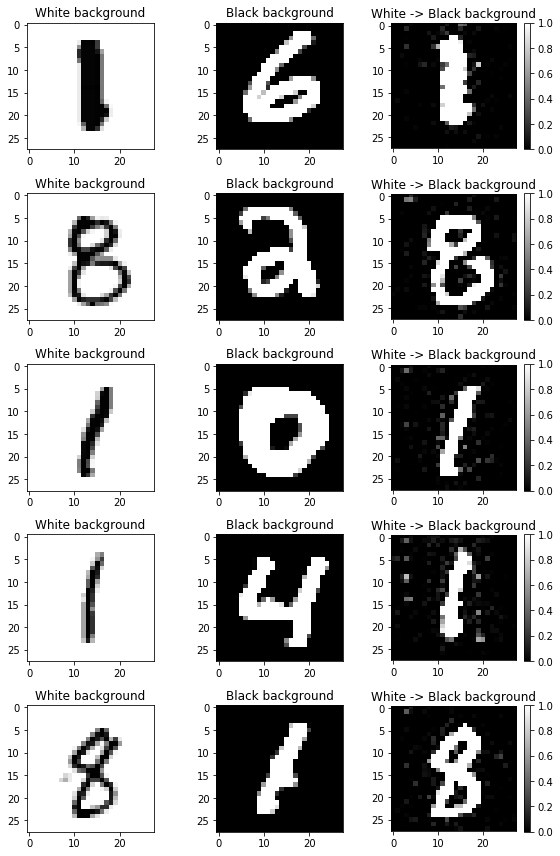

In [26]:
# generator A->B
test_reconstruction = np.reshape(test_reconstruction,(-1,28,28))

plt.figure(figsize=(8, 12))
for i in range(5):
    plt.subplot(5, 3, 3*i + 1)
    plt.imshow(noise_test_batch[i].reshape(28, 28), vmin=0, vmax=1,cmap='gray')
    plt.title("White background")

    
    plt.subplot(5, 3, 3*i + 2)
    plt.imshow(normal[i].reshape(28, 28)*5, vmin=0, vmax=1,cmap='gray')
    plt.title("Black background")

    #plt.grid()
    plt.subplot(5, 3, 3*i + 3)
    plt.imshow(test_reconstruction[i]*5, vmin=0, vmax=1,cmap='gray')
    plt.title("White -> Black background")
    plt.colorbar()
    
    
    #plt.grid()
plt.tight_layout()

### Testing part 2: noise image

We can see that the generator learns to make the background into black and the numbers to white.
Lets try another transformation, we have a noisy image and we want to try and denoise it

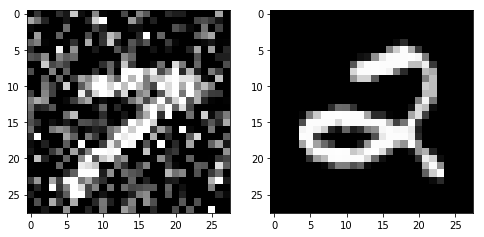

In [27]:
# test whether the scaling works
train_batch, _ = mnist.train.next_batch(batch_size)
# assign each batch some 'scanner' labels
labels = np.random.choice(2,batch_size)

flipped_batch = add_noise(train_batch[labels == 0])
normal_batch = train_batch[labels == 1]
# plot the
plt.figure(figsize=(8,8))
plt.subplot(121)
plt.imshow(np.reshape(flipped_batch[0],(28,28)),cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(normal_batch[0],(28,28)),cmap='gray')

In [28]:
checkpoints_dir = 'model_noise'
graph = tf.get_default_graph()
train_writer = tf.summary.FileWriter(checkpoints_dir, graph)

In [29]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
step = 0.0

In [30]:
for epoch in range(n_epoch):
    n_iter = 50000/batch_size
    
    for i in range(n_iter):
        
        # get the next batch
        train_batch, _ = mnist.train.next_batch(batch_size)
        
        # assign each batch to some 'scanner' labels
        labels = np.random.choice(2,batch_size)
        
        # apply the transformations
        #noise_batch = add_noise(train_batch[labels == 0])
        inverted_batch = add_noise(train_batch[labels == 0])
        normal = train_batch[labels == 1]
        
        _, genB_loss_val,dB_loss_val,summary = (
              sess.run(
                  [optimisers,G_loss,D_loss,summary_op],
                  feed_dict={x_ph_A: inverted_batch,
                            x_ph_B: normal}
              )
        )
        
        if step % 200 == 0:
            print('-----------Step %d:-------------' % step)
            print('  genB_loss   : {:0.3f}'.format(genB_loss_val))
            print('  dB_loss : {:0.3f}'.format(dB_loss_val))
            
        train_writer.add_summary(summary, step)
        
        step += 1

-----------Step 0:-------------
  genB_loss   : 0.713
  dB_loss : 1.402
-----------Step 200:-------------
  genB_loss   : 0.864
  dB_loss : 1.155
-----------Step 400:-------------
  genB_loss   : 1.375
  dB_loss : 1.186
-----------Step 600:-------------
  genB_loss   : 1.241
  dB_loss : 1.156
-----------Step 800:-------------
  genB_loss   : 0.992
  dB_loss : 1.018
-----------Step 1000:-------------
  genB_loss   : 0.976
  dB_loss : 0.966
-----------Step 1200:-------------
  genB_loss   : 0.971
  dB_loss : 1.176
-----------Step 1400:-------------
  genB_loss   : 1.493
  dB_loss : 1.253
-----------Step 1600:-------------
  genB_loss   : 0.931
  dB_loss : 1.288


In [31]:
 # get the next batch
test_batch, _ = mnist.test.next_batch(batch_size)

# assign each batch to some 'scanner' labels
labels = np.random.choice(2,batch_size)

# apply the transformations
noise_test_batch = add_noise(test_batch[labels == 0])
#inverted_batch = invert_image(train_batch[labels == 0])
normal = train_batch[labels == 1]

test_reconstruction = sess.run(genB, feed_dict={x_ph_A:noise_test_batch, x_ph_B:normal})

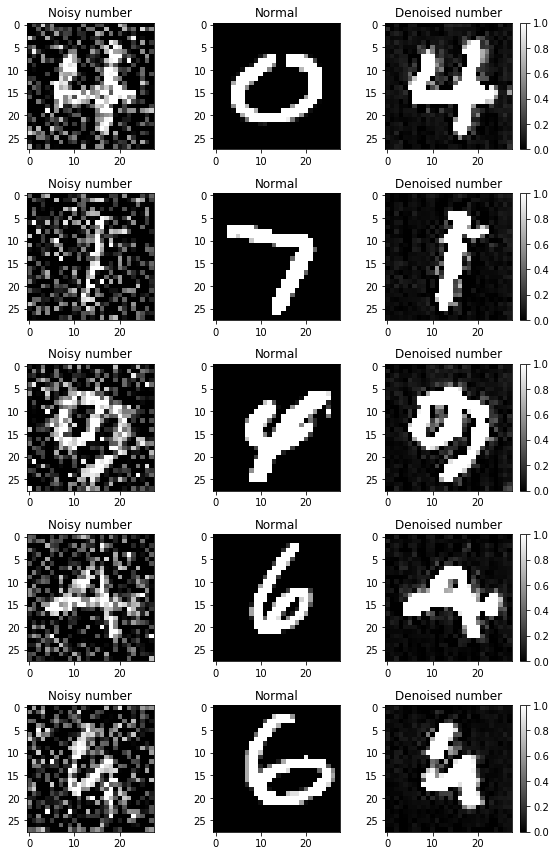

In [32]:
# generator A->B
test_reconstruction = np.reshape(test_reconstruction,(-1,28,28))

plt.figure(figsize=(8, 12))
for i in range(5):
    plt.subplot(5, 3, 3*i + 1)
    plt.imshow(noise_test_batch[i].reshape(28, 28), vmin=0, vmax=1,cmap='gray')
    plt.title("Noisy number")

    
    plt.subplot(5, 3, 3*i + 2)
    plt.imshow(normal[i].reshape(28, 28)*5, vmin=0, vmax=1,cmap='gray')
    plt.title("Normal")

    #plt.grid()
    plt.subplot(5, 3, 3*i + 3)
    plt.imshow(test_reconstruction[i]*5, vmin=0, vmax=1,cmap='gray')
    plt.title("Denoised number")
    plt.colorbar()
    
    
    #plt.grid()
plt.tight_layout()

For some reason it took two tries to get results like this. It seems like its dependent on the initialisation of the network. But it seems to work alright. 

Can we now instead, add noise to an image?

In [33]:
checkpoints_dir = 'model_addnoise'
graph = tf.get_default_graph()
train_writer = tf.summary.FileWriter(checkpoints_dir, graph)

In [34]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
step = 0.0

In [35]:
for epoch in range(n_epoch):
    n_iter = 50000/batch_size
    
    for i in range(n_iter):
        
        # get the next batch
        train_batch, _ = mnist.train.next_batch(batch_size)
        
        # assign each batch to some 'scanner' labels
        labels = np.random.choice(2,batch_size)
        
        # apply the transformations
        #noise_batch = add_noise(train_batch[labels == 0])
        inverted_batch = add_noise(train_batch[labels == 0])
        normal = train_batch[labels == 1]
        
        _, genB_loss_val,dB_loss_val,summary = (
              sess.run(
                  [optimisers,G_loss,D_loss,summary_op],
                  feed_dict={x_ph_A: normal,
                            x_ph_B: inverted_batch}
              )
        )
        
        if step % 200 == 0:
            print('-----------Step %d:-------------' % step)
            print('  genB_loss   : {:0.3f}'.format(genB_loss_val))
            print('  dB_loss : {:0.3f}'.format(dB_loss_val))
            
        train_writer.add_summary(summary, step)
        
        step += 1

-----------Step 0:-------------
  genB_loss   : 0.705
  dB_loss : 1.381
-----------Step 200:-------------
  genB_loss   : 0.639
  dB_loss : 1.416
-----------Step 400:-------------
  genB_loss   : 0.670
  dB_loss : 1.414
-----------Step 600:-------------
  genB_loss   : 0.687
  dB_loss : 1.387
-----------Step 800:-------------
  genB_loss   : 0.738
  dB_loss : 1.333
-----------Step 1000:-------------
  genB_loss   : 0.645
  dB_loss : 1.430
-----------Step 1200:-------------
  genB_loss   : 0.696
  dB_loss : 1.385
-----------Step 1400:-------------
  genB_loss   : 0.689
  dB_loss : 1.401
-----------Step 1600:-------------
  genB_loss   : 0.706
  dB_loss : 1.361


In [36]:
 # get the next batch
test_batch, _ = mnist.test.next_batch(batch_size)

# assign each batch to some 'scanner' labels
labels = np.random.choice(2,batch_size)

# apply the transformations
noise_test_batch = add_noise(test_batch[labels == 0])
#inverted_batch = invert_image(train_batch[labels == 0])
normal = train_batch[labels == 1]

test_reconstruction = sess.run(genB, feed_dict={x_ph_A:normal, x_ph_B:noise_test_batch})

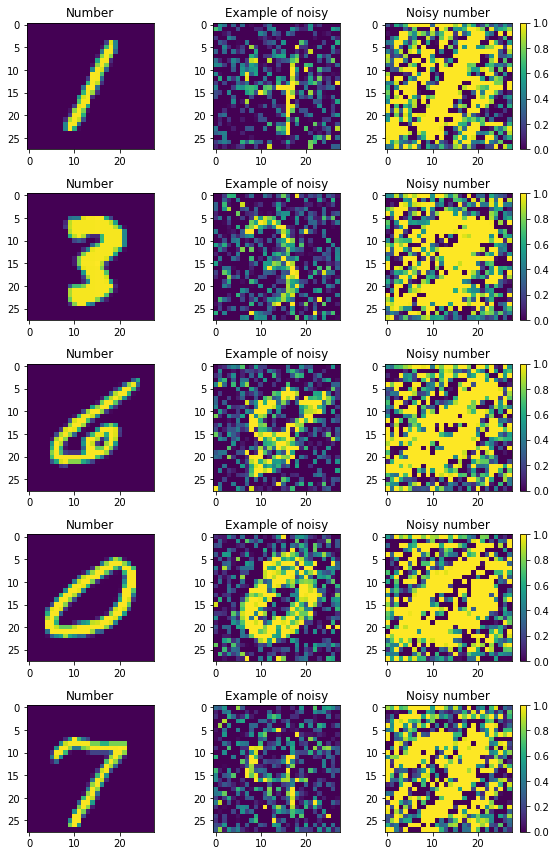

In [37]:
# generator A->B
test_reconstruction = np.reshape(test_reconstruction,(-1,28,28))

plt.figure(figsize=(8, 12))
for i in range(5):
    plt.subplot(5, 3, 3*i + 1)
    plt.imshow(normal[i].reshape(28, 28), vmin=0, vmax=1)
    plt.title("Number")

    
    plt.subplot(5, 3, 3*i + 2)
    plt.imshow(noise_test_batch[i].reshape(28, 28), vmin=0, vmax=1)
    plt.title("Example of noisy")

    #plt.grid()
    plt.subplot(5, 3, 3*i + 3)
    plt.imshow(test_reconstruction[i]*5, vmin=0, vmax=1)
    plt.title("Noisy number")
    plt.colorbar()
    
    
    #plt.grid()
plt.tight_layout()

If you look pretty hard, you can see the number lying underneath the noise! However the amount of noise added isn't exactly the same

Lets see if we could automatcally change between different types of noise

In [38]:
from skimage.util import random_noise

In [39]:
def salt_pepper(batch):
    for i in range(batch.shape[0]):
        batch[i] = random_noise(np.reshape(batch[i],(28,28)),'s&p',amount=0.3).flatten()
    return batch

In [40]:
def speckle_noise(batch):
    for i in range(batch.shape[0]):
        batch[i] = random_noise(np.reshape(batch[i],(28,28)),'speckle',var=0.3).flatten()
    return batch

In [41]:
def guassian_noise(batch):
    for i in range(batch.shape[0]):
        batch[i] = random_noise(np.reshape(batch[i],(28,28)),'gaussian',var=0.2).flatten()
    return batch

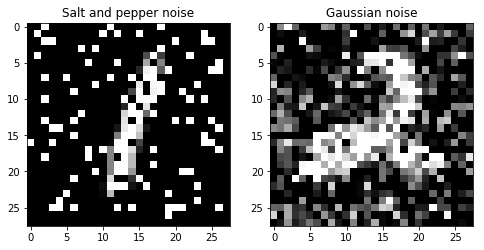

In [42]:
# test whether the scaling works
train_batch, _ = mnist.train.next_batch(batch_size)
# assign each batch some 'scanner' labels
labels = np.random.choice(2,batch_size)

s_p_batch = salt_pepper(train_batch[labels == 0])
poisson_batch = guassian_noise(train_batch[labels == 1])
# plot the
plt.figure(figsize=(8,8))
plt.subplot(121)
plt.imshow(np.reshape(s_p_batch[0],(28,28)),cmap='gray')
plt.title('Salt and pepper noise')
plt.subplot(122)
plt.imshow(np.reshape(poisson_batch[0],(28,28)),cmap='gray')
plt.title('Gaussian noise')

In [43]:
checkpoints_dir = 'model_salt_pepper'
graph = tf.get_default_graph()
train_writer = tf.summary.FileWriter(checkpoints_dir, graph)

In [44]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
step = 0.0

In [51]:
for epoch in range(n_epoch):
    n_iter = 50000/batch_size
    
    for i in range(n_iter):
        
        # get the next batch
        train_batch, _ = mnist.train.next_batch(batch_size)
        
        # assign each batch to some 'scanner' labels
        labels = np.random.choice(2,batch_size)
        
        # apply the transformations
        s_p_batch = salt_pepper(train_batch[labels == 0])
        gaussian_batch = guassian_noise(train_batch[labels == 1])
        
        _, genB_loss_val,dB_loss_val,summary = (
              sess.run(
                  [optimisers,G_loss,D_loss,summary_op],
                  feed_dict={x_ph_A: s_p_batch,
                            x_ph_B: gaussian_batch}
              )
        )
        
        if step % 200 == 0:
            print('-----------Step %d:-------------' % step)
            print('  genB_loss   : {:0.3f}'.format(genB_loss_val))
            print('  dB_loss : {:0.3f}'.format(dB_loss_val))
            
        train_writer.add_summary(summary, step)
        
        step += 1

-----------Step 3400:-------------
  genB_loss   : 0.622
  dB_loss : 1.483
-----------Step 3600:-------------
  genB_loss   : 0.558
  dB_loss : 1.614
-----------Step 3800:-------------
  genB_loss   : 0.699
  dB_loss : 1.395
-----------Step 4000:-------------
  genB_loss   : 0.655
  dB_loss : 1.437
-----------Step 4200:-------------
  genB_loss   : 0.750
  dB_loss : 1.304
-----------Step 4400:-------------
  genB_loss   : 0.695
  dB_loss : 1.410
-----------Step 4600:-------------
  genB_loss   : 0.734
  dB_loss : 1.361
-----------Step 4800:-------------
  genB_loss   : 0.765
  dB_loss : 1.297


In [52]:
 # get the next batch
test_batch, _ = mnist.test.next_batch(batch_size)

# assign each batch to some 'scanner' labels
labels = np.random.choice(2,batch_size)

# apply the transformations
s_p_batch = salt_pepper(test_batch[labels == 0])
gaussian_batch = guassian_noise(test_batch[labels == 1])

test_reconstruction = sess.run(genB, feed_dict={x_ph_A:s_p_batch, x_ph_B:gaussian_batch})

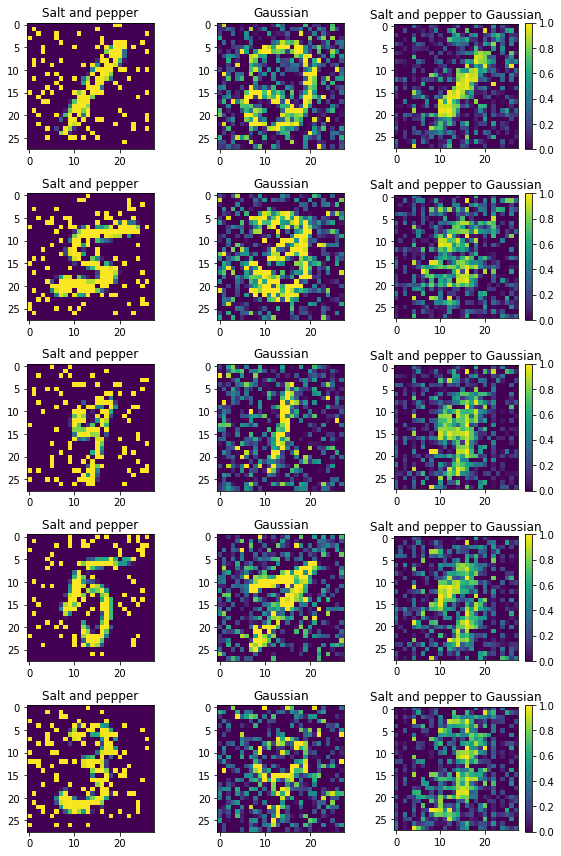

In [53]:
# generator A->B
test_reconstruction = np.reshape(test_reconstruction,(-1,28,28))

plt.figure(figsize=(8, 12))
for i in range(5):
    plt.subplot(5, 3, 3*i + 1)
    plt.imshow(s_p_batch[i].reshape(28, 28), vmin=0, vmax=1)
    plt.title("Salt and pepper")

    
    plt.subplot(5, 3, 3*i + 2)
    plt.imshow(gaussian_batch[i].reshape(28, 28), vmin=0, vmax=1)
    plt.title("Gaussian")

    #plt.grid()
    plt.subplot(5, 3, 3*i + 3)
    plt.imshow(test_reconstruction[i], vmin=0, vmax=1)
    plt.title("Salt and pepper to Gaussian")
    plt.colorbar()
    
    
    #plt.grid()
plt.tight_layout()

In [59]:
# lets try the other way
checkpoints_dir = 'model_salt_pepper_reversed'
graph = tf.get_default_graph()
train_writer = tf.summary.FileWriter(checkpoints_dir, graph)

In [60]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
step = 0.0

In [61]:
for epoch in range(n_epoch):
    n_iter = 50000/batch_size
    
    for i in range(n_iter):
        
        # get the next batch
        train_batch, _ = mnist.train.next_batch(batch_size)
        
        # assign each batch to some 'scanner' labels
        labels = np.random.choice(2,batch_size)
        
        # apply the transformations
        s_p_batch = salt_pepper(train_batch[labels == 0])
        gaussian_batch = guassian_noise(train_batch[labels == 1])
        
        _, genB_loss_val,dB_loss_val,summary = (
              sess.run(
                  [optimisers,G_loss,D_loss,summary_op],
                  feed_dict={x_ph_A: gaussian_batch,
                            x_ph_B: s_p_batch}
              )
        )
        
        if step % 200 == 0:
            print('-----------Step %d:-------------' % step)
            print('  genB_loss   : {:0.3f}'.format(genB_loss_val))
            print('  dB_loss : {:0.3f}'.format(dB_loss_val))
            
        train_writer.add_summary(summary, step)
        
        step += 1

-----------Step 0:-------------
  genB_loss   : 0.706
  dB_loss : 1.382
-----------Step 200:-------------
  genB_loss   : 0.690
  dB_loss : 1.411
-----------Step 400:-------------
  genB_loss   : 0.753
  dB_loss : 1.334
-----------Step 600:-------------
  genB_loss   : 0.678
  dB_loss : 1.409
-----------Step 800:-------------
  genB_loss   : 0.713
  dB_loss : 1.396
-----------Step 1000:-------------
  genB_loss   : 0.735
  dB_loss : 1.316
-----------Step 1200:-------------
  genB_loss   : 0.659
  dB_loss : 1.253
-----------Step 1400:-------------
  genB_loss   : 4.150
  dB_loss : 0.173
-----------Step 1600:-------------
  genB_loss   : 3.407
  dB_loss : 0.147


In [62]:
 # get the next batch
test_batch, _ = mnist.test.next_batch(batch_size)

# assign each batch to some 'scanner' labels
labels = np.random.choice(2,batch_size)

# apply the transformations
s_p_batch = salt_pepper(test_batch[labels == 0])
gaussian_batch = guassian_noise(test_batch[labels == 1])

test_reconstruction = sess.run(genB, feed_dict={x_ph_A:gaussian_batch, x_ph_B:s_p_batch})

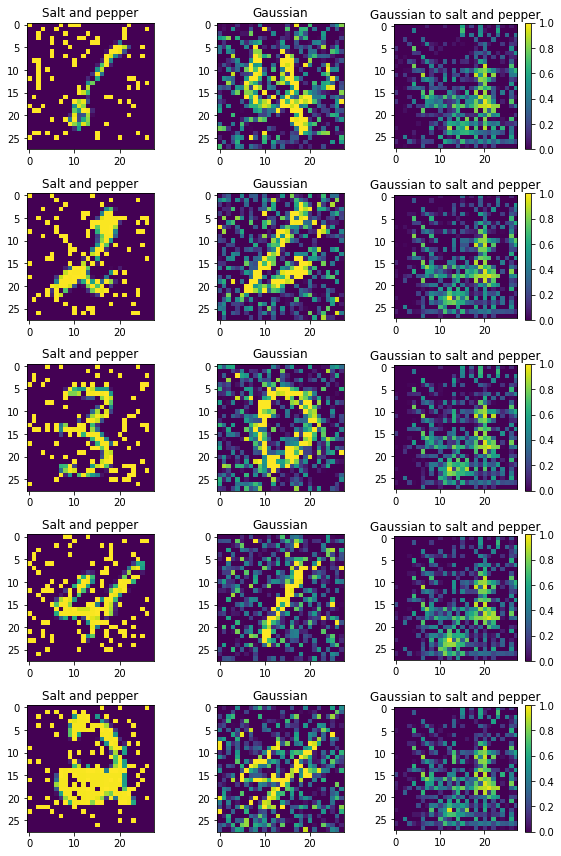

In [63]:
# generator A->B
test_reconstruction = np.reshape(test_reconstruction,(-1,28,28))

plt.figure(figsize=(8, 12))
for i in range(5):
    plt.subplot(5, 3, 3*i + 1)
    plt.imshow(s_p_batch[i].reshape(28, 28), vmin=0, vmax=1)
    plt.title("Salt and pepper")

    
    plt.subplot(5, 3, 3*i + 2)
    plt.imshow(gaussian_batch[i].reshape(28, 28), vmin=0, vmax=1)
    plt.title("Gaussian")

    #plt.grid()
    plt.subplot(5, 3, 3*i + 3)
    plt.imshow(test_reconstruction[i], vmin=0, vmax=1)
    plt.title("Gaussian to salt and pepper")
    plt.colorbar()
    
    
    #plt.grid()
plt.tight_layout()